In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
import os
from scipy.stats import pearsonr
from scipy.spatial.distance import braycurtis
from sklearn.metrics import r2_score
from scipy import stats
from statannot import add_stat_annotation
%matplotlib inline

# Read taxonomy

In [2]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,f5f5e0da89730462abaf6301a9557193,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.997650,g__Faecalibacterium
1,99deb3c5ecb022ec05609ebd1112a557,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
2,c6c3ab4e828fb40d6e05967b7aac9338,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.948118,g__Blautia
3,d46e2205f0c6ecf67b51f83d111c509c,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.919473,g__Escherichia-Shigella
4,818434292143daca42a3168f3728da82,d__Bacteria; p__Firmicutes; c__Negativicutes; ...,0.999921,g__Dialister


# Read metadata

In [3]:
df_meta = pd.read_csv("ibd_gevers_2014.metadata.txt", sep="\t")
df_meta = df_meta[df_meta.sample_location == "stool"]
df_run = pd.read_csv("qiime2_output/SraRunTable.txt")[['Run','Sample Name']]
df_run.columns = ['run','sample']
df_meta = pd.merge(df_meta, df_run, left_on='sample', right_on='sample', how='inner').set_index('run')
df_meta.head()

,sample,subject,AB_exposure,Diagnosis,PCDAI,race,sample_location,DiseaseState
run,,,,,,,,
SRR1210718,SKSTL0070,M1-0852,NoAB,CD,35.0,caucasian,stool,CD
SRR1210660,SKSTL0073,M1-0889,NoAB,CD,65.0,caucasian,stool,CD
SRR1211711,SKSTL0074,M1-0924,NoAB,CD,5.0,african,stool,CD
SRR1212457,SKSTL0075,M1-0563,NoAB,CD,47.5,caucasian,stool,CD
SRR1211405,SKSTL0076,M1-0561,NoAB,CD,25.0,caucasian,stool,CD


# Read count data (filter out samples with less than 1000 reads)

In [4]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 4163


#OTU ID,f5f5e0da89730462abaf6301a9557193,99deb3c5ecb022ec05609ebd1112a557,c6c3ab4e828fb40d6e05967b7aac9338,d46e2205f0c6ecf67b51f83d111c509c,818434292143daca42a3168f3728da82,c24e0e391aa836b5eae25567c7eb89ee,e865f29a716e8d51f83931befa951240,263e41ea2c25dc87bd2ff5910cf30d40,fd496fd32dc8c08ade2e8b6c9d8ee13d,8e175abe6a746b8f33bae9cd7c8192bb,...,48ee5e7bc59ccab5e105039dee26b751,390a2bf17f60255014841a31dbba7ca9,3a818bb79b22d1d93da749886e34f808,ec6841f35bc0a42185b0ef406209ba12,d829bee4984f82ffc2453212157caf96,eb6ee3fb31b9446824c8a2b826a11d6a,1dc944da5511fe373f255e772cb3b61d,0977d4dea582096116326eb1de80369e,5520af1f205a1d6ddea74bcc274ad7d5,cf44f8d0c51c26e2f38a774d1c0c546b
SRR1211105,0.018063,0.001014,0.125127,0.003880,0.000000,0.000463,0.090442,0.044545,0.022281,0.001780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR1211142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR1211687,0.163643,0.038660,0.040840,0.007675,0.095135,0.000000,0.024110,0.005464,0.010676,0.019899,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR1211133,0.017469,0.007808,0.046993,0.055343,0.000521,0.028941,0.000000,0.002811,0.001895,0.027109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR1210718,0.000000,0.000338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000290,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compare Streptococcus relative abundance between HC and CD

In [26]:
# healthy control
df_relabun.loc[df_meta[(df_meta.AB_exposure=='NoAB') & (df_meta.DiseaseState=='nonIBD')].index, df_tax[df_tax.Taxon.str.contains('Streptococcus')].ASV].sum(axis=1).mean()

0.017605455970493643

In [25]:
# healthy control
df_relabun.loc[df_meta[(df_meta.AB_exposure=='NoAB') & (df_meta.DiseaseState=='CD')].index, df_tax[df_tax.Taxon.str.contains('Streptococcus')].ASV].sum(axis=1).mean()

0.04291281968209886

# Compare oral bacterial fraction between disease severity

In [5]:
df_blast_HMPv35oral = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_oral = df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1)
df_meta_oral = pd.merge(df_meta, df_oral, left_index=True, right_index=True, how='inner')
df_meta_oral['log10_OralFrac'] = np.log10(df_meta_oral['OralFrac'])
df_meta_oral = df_meta_oral[df_meta_oral.AB_exposure=='NoAB']
df_meta_oral.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,sample,subject,AB_exposure,Diagnosis,PCDAI,race,sample_location,DiseaseState,OralFrac,log10_OralFrac
SRR1210718,SKSTL0070,M1-0852,NoAB,CD,35.0,caucasian,stool,CD,0.648897,-0.187824
SRR1210660,SKSTL0073,M1-0889,NoAB,CD,65.0,caucasian,stool,CD,0.033112,-1.480015
SRR1211711,SKSTL0074,M1-0924,NoAB,CD,5.0,african,stool,CD,0.037355,-1.427654
SRR1212457,SKSTL0075,M1-0563,NoAB,CD,47.5,caucasian,stool,CD,0.008876,-2.051765
SRR1211405,SKSTL0076,M1-0561,NoAB,CD,25.0,caucasian,stool,CD,0.000399,-3.398721


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

nonIBD v.s. CD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.382e-02 U_stat=5.950e+02


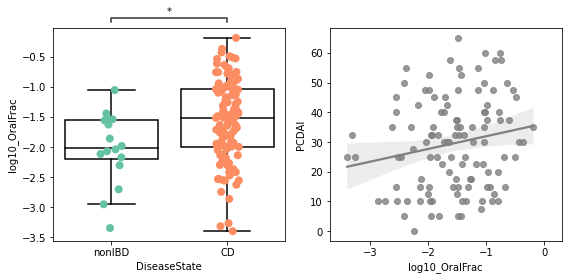

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}
_ = sns.stripplot(x="DiseaseState", y="log10_OralFrac", data=df_meta_oral, palette="Set2", ax=ax[0], order=['nonIBD','CD'], s=8)
_ = sns.boxplot(x="DiseaseState", y="log10_OralFrac", data=df_meta_oral, palette="Set2", ax=ax[0], order=['nonIBD','CD'], showfliers=False, **PROPS)
test_results = add_stat_annotation(ax[0], data=df_meta_oral, x="DiseaseState", y="log10_OralFrac", order=["nonIBD","CD"],
                                   box_pairs=[("nonIBD", "CD")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

_ = sns.regplot(x="log10_OralFrac", y="PCDAI", data=df_meta_oral[(df_meta_oral.DiseaseState=='CD') & (df_meta_oral.OralFrac>0)], ax=ax[1], color="gray")
_ = ax[1].set_xlim([-3.7,0.3])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("boxplot_CD_nonIBD.svg", dpi=600, bbox_inches='tight')

In [7]:
res = stats.linregress(df_meta_oral[(df_meta_oral.DiseaseState=='CD') & (df_meta_oral.OralFrac>0) & (df_meta_oral.PCDAI.notnull())].log10_OralFrac.values, 
                       df_meta_oral[(df_meta_oral.DiseaseState=='CD') & (df_meta_oral.OralFrac>0) & (df_meta_oral.PCDAI.notnull())].PCDAI.values)
print(res.slope, res.rvalue, res.pvalue)

4.274344210713884 0.182269571475197 0.05226424098987999


In [8]:
df_meta_oral = df_meta_oral[df_meta_oral.DiseaseState != "nonIBD"]
print(set(df_meta_oral.DiseaseState))
df_meta_oral['ScoreCat'] = 'Unknown'
df_meta_oral.loc[df_meta_oral.PCDAI<=10, 'ScoreCat'] = 'Remission'
df_meta_oral.loc[(df_meta_oral.PCDAI>10)&(df_meta_oral.PCDAI<=30), 'ScoreCat'] = 'Mild'
df_meta_oral.loc[df_meta_oral.PCDAI>30, 'ScoreCat'] = 'Moderate-Severe'

{'CD'}


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Remission v.s. Mild: Welch's t-test independent samples with Bonferroni correction, P_val=2.867e-01 stat=-1.494e+00
Remission v.s. Moderate-Severe: Welch's t-test independent samples with Bonferroni correction, P_val=1.100e-01 stat=-1.990e+00


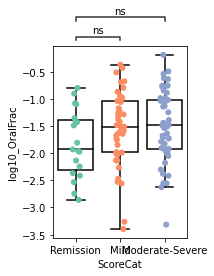

In [12]:
fig, ax = plt.subplots(figsize=(3,4))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}
df_meta_oral2 = df_meta_oral[df_meta_oral.OralFrac>0]
_ = sns.stripplot(x="ScoreCat", y="log10_OralFrac", data=df_meta_oral2, palette="Set2", ax=ax, order=['Remission','Mild','Moderate-Severe'], s=6)
_ = sns.boxplot(x="ScoreCat", y="log10_OralFrac", data=df_meta_oral2, palette="Set2", ax=ax, order=['Remission','Mild','Moderate-Severe'], showfliers=False, **PROPS)
test_results = add_stat_annotation(ax, data=df_meta_oral2, x="ScoreCat", y="log10_OralFrac", order=['Remission','Mild','Moderate-Severe'],
                                   box_pairs=[("Remission", "Mild"),("Remission","Moderate-Severe")],
                                   test='t-test_welch', text_format='star',
                                   loc='outside', verbose=2)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("assoc_oral_disease_status.svg", dpi=600, bbox_inches='tight')